## Streaming Kaplan-Meier

When data is streaming, it is being updated all the time, which affects Kaplan-Meier estimator. Previously, we could use new data to update model/estimation (trained/estimated by old data) through updating some finite parameters, but now we need to update a function. And the challenge is the streaming data specifically for Kaplan-Meier estimator has orders (time) and we couldn't directly use it to update the function, instead first we need to identify an appropriate position for the new data (specifically for the `t`), then update $(t_j, d_j, n_j)_{j=1}^n$ using new data $\{(T_i, \delta_i)\}_{i=1}^n$, and finally we could update Kaplan-Meier estimator using the formula $\hat S(t) = \prod_{l: t_l \leqq t} (1 - \frac{d_l}{n_l})$ because it's a one-to-one mapping between the estimator and $(t_j, d_j, n_j)_{j=1}^n$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bisect 

In [11]:
def update_KM(T_list = [], delta_list = [], t_ori = [], d_ori = [], n_ori = []):
    '''
    The function updates the Kaplan-Meier estimator using new data(T, delta)
    
    @Parameters:
    T_list: new data for the censoring or failure time 
    delta_list: censoring indicator (delta=0 if failure)
    t_ori: exsisting observed time list 
    d_ori: number of failures at each t in t_list
    n_ori: number at risk at each t in t_list (the number of survivals right before time t)
    
    @Returns:
    t_list, d_list, n_list: updated corresponding lists
    KM_estimator: Kaplan-Meier estimator (a function of t)
    '''
    
    t_list = t_ori.copy()
    d_list = d_ori.copy()
    n_list = n_ori.copy()
    
    for t, delta in zip(T_list, delta_list):
        # if new t is already in the old data 
        if t in t_list:
            # find the index for this new t
            index = t_list.index(t)
            # if the new observation is dead, then add 1 to the specific time (d_list)
            d_list[index] += int(delta == 0)
            # add 1 survival to all ns before(and include) the index 
            n_list[:(index + 1)] = [n + 1 for n in n_list[:(index + 1)]] 
            # if the new observation is alive, then add 1 to all ns after the index+1, otherwise add 0
            n_list[(index + 1): ] = [n + int(delta == 1) for n in n_list[(index + 1): ]]
        # if new t does not exsist in the old data
        else:
            # insert new t into t_list and sort the time to have the ascending order 
            bisect.insort(t_list, t)
            # find the index for this new t
            index = t_list.index(t)
            # insert 1 if the new observation is dead 
            d_list.insert(index, int(delta == 0))
            # add 1 survival to all ns before(not include) the index 
            n_list[:index] = [n + 1 for n in n_list[:index]]
            # if the new observation is alive, then add 1 to all ns after the index, otherwise add 0
            n_list[index:] = [n + int(delta == 1) for n in n_list[index:]]
            # insert the number of survivals for the index into n_list if the index>1 
            # using the difference between ns and ds (the number of survivals and the number of death)
            # otherwise 0
            n_list.insert(index, n_list[index - 1] - d_list[index - 1] if index > 0 else 1)
            
    KM_estimator = lambda t: np.prod([1 - dj / nj for tj, dj, nj in zip(t_list, d_list, n_list) if tj <= t])
    
    return (t_list, d_list, n_list), KM_estimator

## Example: 

First we create two sets of data, one indicating the old data, the other one is the new data, and then we will use the new data to update Kaplan-Meier estimator and show the plot to verify our function.

In [15]:
np.random.seed(seed=123)
# first set of data
T_list = np.arange(0, 40, 1)
delta_list = np.random.randint(0, 2, 40)
(t_list1, d_list1, n_list1), KM1 = update_KM(T_list, delta_list)
print(t_list1)
print(d_list1)
print(n_list1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
[40, 39, 39, 38, 37, 36, 35, 34, 34, 34, 33, 33, 33, 32, 32, 31, 31, 30, 30, 30, 29, 28, 27, 27, 27, 27, 26, 26, 25, 24, 23, 22, 22, 22, 22, 21, 20, 20, 19, 18]


In [17]:
# second set of data
T_new = np.arange(0, 40, 0.5)
delta_new = np.random.randint(0, 2, 80)
(t_list2, d_list2, n_list2), KM2 = update_KM(T_new, delta_new, t_list1, d_list1, n_list1)
# updated lists
print(t_list2)
print(d_list2)
print(n_list2)

[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5]
[2, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0]
[120, 118, 118, 117, 117, 116, 116, 114, 113, 111, 110, 109, 109, 107, 106, 106, 105, 105, 104, 102, 102, 101, 101, 100, 100, 98, 97, 96, 95, 94, 93, 92, 92, 91, 91, 91, 90, 89, 88, 86, 86, 85, 84, 82, 81, 80, 80, 79, 79, 79, 78, 77, 77, 77, 76, 75, 75, 74, 73, 71, 70, 69, 68, 67, 67, 67, 67, 66, 66, 65, 64, 62, 62, 62, 61, 60, 60, 59, 59, 59]


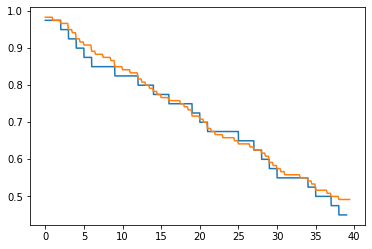

In [18]:
# first set of data to estimate KM
ts1 = np.arange(min(t_list1), max(t_list1), 0.01)
S1 = list(map(KM1, ts1))
plt.plot(ts1, S1, label = "old estimator")

# second set of data to update KM
ts2 = np.arange(np.min(t_list2), np.max(t_list2), 0.1)
S2 = list(map(KM2, ts2))
plt.plot(ts2, S2, label = "updated estimator")